# Truecolor Image Generation from Satellite Data

This notebook demonstrates the process of generating a truecolor image from satellite reflectance data.

Steps:
1. Import necessary libraries.
2. Locate satellite data files.
3. Load required reflectance bands (Red, Green, Blue).
4. Extract data using GPU acceleration.
5. Define a region of interest (bounding box) and binning parameters.
6. Bin the reflectance data for each band.
6a. Selectively interpolate NaN regions.
7. Combine the binned data into an RGB truecolor image.
8. Plot the truecolor image on a map.

### 1. Import Libraries

In [100]:
# Import essential libraries
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d
from scipy.ndimage import gaussian_filter # Added for blurring

# Import custom pipeline modules
from l2_pipeline import L2DatasetLoader, GPUDataExtractor, SelectiveInterpolator # Added SelectiveInterpolator

### 2. Search for Data Files

In [101]:
# Specify the data directory and search recursively for netCDF files
data_dir = r"E:\satdata\Mississippi_2021-06-21_2021-07-21"
nc_files = glob.glob(os.path.join(data_dir, '**', '*.nc'), recursive=True)
print(f"Found {len(nc_files)} files.")

Found 41 files.


### 3. Load Datasets

Load the Red (Rrs_645), Green (Rrs_555), and Blue (Rrs_469) reflectance bands.

In [102]:
# Define the variables needed for truecolor
truecolor_vars = ['Rrs_645', 'Rrs_555', 'Rrs_469']

# Load datasets using L2DatasetLoader
loader = L2DatasetLoader(variables=truecolor_vars)
datasets = loader.load_multiple(nc_files)
print(f"Loaded {len(datasets)} datasets.")

Loaded 41 datasets.


### 4. Extract Data using GPU

In [103]:
# Create an instance of GPUDataExtractor and extract data
extractor = GPUDataExtractor(variables=truecolor_vars)
all_lon, all_lat, all_vars_dict = extractor.extract(datasets)
print('GPU data extraction complete.')
print(f"Extracted data points: {len(all_lon)}")
print(f"Available variables: {list(all_vars_dict.keys())}")

GPU data extraction complete.
Extracted data points: 12032063
Available variables: ['Rrs_645', 'Rrs_555', 'Rrs_469']


### 5. Define Bounding Box and Binning Parameters

In [104]:
# Define Bounding Box for the region of interest
lon_min, lon_max = -91.5, -87.5
lat_min, lat_max = 28.0, 30.0

# Define binning parameters (adjust for desired resolution)
lat_bins, lon_bins = 200, 300 # Increased resolution for image

### 6. Bin Reflectance Data

Compute the 2D binned mean statistic for each reflectance band within the bounding box.

In [105]:
# Clip data to the bounding box
mask = ((all_lon >= lon_min) & (all_lon <= lon_max) & (all_lat >= lat_min) & (all_lat <= lat_max))
clipped_lon = all_lon[mask]
clipped_lat = all_lat[mask]

# Bin each variable separately
binned_stats = {}
for var in truecolor_vars:
    clipped_var = all_vars_dict[var][mask]
    stat, lat_edges, lon_edges, _ = binned_statistic_2d(
        clipped_lat, clipped_lon, clipped_var, statistic='mean', bins=[lat_bins, lon_bins],
        range=[[lat_min, lat_max], [lon_min, lon_max]]
    )
    binned_stats[var] = stat
    print(f"Binned {var}")

# Generate meshgrid for plotting using bin edges
lon_grid, lat_grid = np.meshgrid(lon_edges, lat_edges)

# Extract binned data for R, G, B channels
r_band = binned_stats['Rrs_645']
g_band = binned_stats['Rrs_555']
b_band = binned_stats['Rrs_469']

Binned Rrs_645
Binned Rrs_555
Binned Rrs_469


### 6a. Selectively Interpolate NaN Regions

Apply selective NaN interpolation to fill small gaps (less than 32 connected bins) in each color band independently.

In [106]:
# Set the threshold for small regions
threshold = 32

# Interpolate each band
print(f"Applying selective interpolation (threshold={threshold})...")
r_band_interp = SelectiveInterpolator.interpolate(r_band, lat_edges, lon_edges, threshold)
print("Interpolated R band.")
g_band_interp = SelectiveInterpolator.interpolate(g_band, lat_edges, lon_edges, threshold)
print("Interpolated G band.")
b_band_interp = SelectiveInterpolator.interpolate(b_band, lat_edges, lon_edges, threshold)
print("Interpolated B band.")
print("Selective interpolation complete.")

Applying selective interpolation (threshold=32)...
Interpolated R band.
Interpolated R band.
Interpolated G band.
Interpolated G band.
Interpolated B band.
Selective interpolation complete.
Interpolated B band.
Selective interpolation complete.


### 7. Create Truecolor Image

Combine the *interpolated* binned Red, Green, and Blue bands into an RGB image. Apply contrast stretching for better visualization.

In [107]:
# Stack the INTERPOLATED bands into an RGB image (Height, Width, Channels)
# Note: The output of binned_statistic_2d is (lat_bins, lon_bins), matching (Height, Width)
rgb_image = np.stack([r_band_interp, g_band_interp, b_band_interp], axis=-1)

# --- Contrast Stretching (Simple Percentile Clip) ---
# Handle potential NaNs before calculating percentiles
valid_mask = ~np.isnan(rgb_image)
vmin, vmax = np.percentile(rgb_image[valid_mask], [1, 99]) # Adjust percentiles as needed

# Clip values
rgb_stretched = np.clip(rgb_image, vmin, vmax)

# Normalize to 0-1 range
rgb_normalized = (rgb_stretched - vmin) / (vmax - vmin)

# Handle NaNs: Set NaN pixels to black (or another background color)
rgb_normalized[np.isnan(rgb_image)] = 0 # Set NaNs in original to 0 in final image

print(f"RGB image shape: {rgb_normalized.shape}")
print(f"Value range after normalization: {np.nanmin(rgb_normalized):.2f} - {np.nanmax(rgb_normalized):.2f}")

RGB image shape: (200, 300, 3)
Value range after normalization: 0.00 - 1.00


### 8. Plot Truecolor Image

Applied Gaussian blur with sigma=1
Using BLURRED Rrs_645 threshold for contour: 0.0010


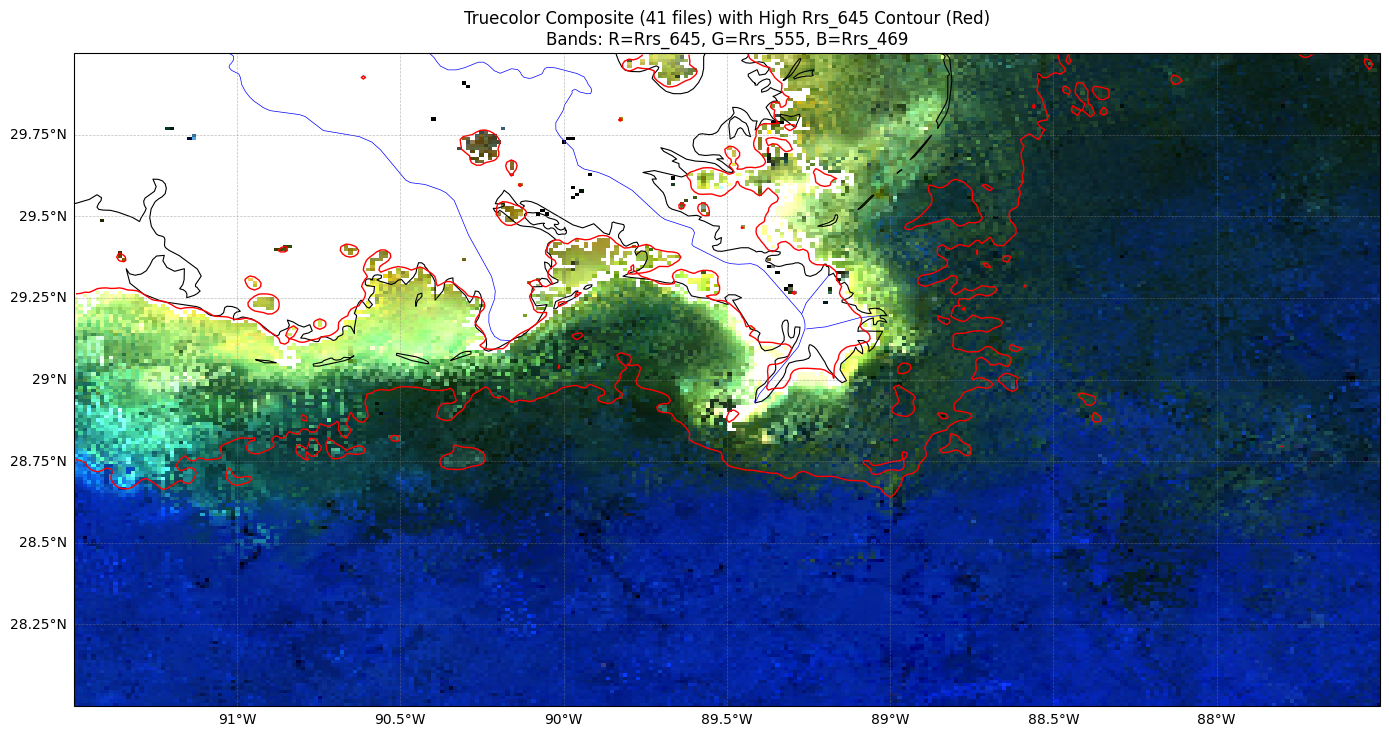

In [108]:
# === Plotting the Truecolor Image ===
fig = plt.figure(figsize=(12,8)) # Adjusted figure size
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the map extent using the bounding box
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# --- Modify rgb_normalized for white background ---
# Identify pixels where *all* original RGB channels were NaN
# Note: Cell 16 already set these pixels to 0 (black) in rgb_normalized
original_nan_mask = np.isnan(rgb_image).all(axis=-1)
# Set these pixels to white (1.0) in the normalized image
rgb_normalized[original_nan_mask] = 1.0

# Plot the RGB image using imshow
# Need to specify extent: [lon_min, lon_max, lat_min, lat_max]
# origin='lower' is typical for lat/lon grids where latitude increases upwards
img_extent = (lon_edges[0], lon_edges[-1], lat_edges[0], lat_edges[-1])
ax.imshow(rgb_normalized, origin='lower', extent=img_extent, transform=ccrs.PlateCarree())

# --- Add Contour Lines for High Rrs_645 (TSS Proxy) ---
# Calculate bin centers
lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2
lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2
lon_center_grid, lat_center_grid = np.meshgrid(lon_centers, lat_centers)

# Apply Gaussian Blur
sigma = 1 # Standard deviation for the blur
r_band_blurred = r_band_interp.copy() # Create a copy
r_band_blurred[np.isnan(r_band_blurred)] = 0 # Replace NaNs with 0 before blurring
r_band_blurred = gaussian_filter(r_band_blurred, sigma=sigma)
print(f"Applied Gaussian blur with sigma={sigma}")

# Calculate threshold (e.g., 75th percentile of *blurred* valid Rrs_645 data)
# Note: Blurred data should not have NaNs if original NaNs were replaced
valid_r_band_blurred = r_band_blurred[~original_nan_mask] # Use original mask to exclude areas that were initially NaN
if len(valid_r_band_blurred) > 0:
    tss_threshold = np.percentile(valid_r_band_blurred, 75) # Adjust percentile as needed
    print(f"Using BLURRED Rrs_645 threshold for contour: {tss_threshold:.4f}")
    # Add contour plot using BLURRED data
    contour_plot = ax.contour(lon_center_grid, lat_center_grid, r_band_blurred,
                              levels=[tss_threshold], colors='red', linewidths=1.0,
                              transform=ccrs.PlateCarree())
    # Optional: Add labels to contours
    # ax.clabel(contour_plot, inline=True, fontsize=8, fmt='%.4f')
else:
    print("No valid blurred Rrs_645 data to generate contours.")

# Add coastlines and land features for context
# Adjusted feature colors for better contrast on white background
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black') # Changed from yellow
ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='darkgray', alpha=0.3) # Added subtle land color
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='darkgray') # Changed from gray
ax.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue') # Kept blue

# Add Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Display map title
plt.title(f"Truecolor Composite ({len(datasets)} files) with High Rrs_645 Contour (Red)\nBands: R={truecolor_vars[0]}, G={truecolor_vars[1]}, B={truecolor_vars[2]}")
plt.tight_layout()
plt.show()